# Моделирование роя в $\mathbb{R}^1$: полная информация об агентах, централизованное управление

## Модель роя

Если в момент $t$ мы в течение $Δ t$ сообщаем телу в точке $x(t)$ со скоростью $v(t)$ ускорение $a$, то в момент времени $t+Δt$ имеем
$$
x(t+Δt) = x(t) + v(t) Δ t + \frac{1}{2} a (Δ t)^2
$$
$$
v(t+Δt) = v(t) + a Δ t
$$

Если представляем нашу модель роя во времени и вне зависимости от характера управления, то всякая сила оказанная в ходе управления дронами эквивалентна сообщению ускорений. То есть каждый мин отрезок времени $Δ t$ происходит изменение состояния системы $(x_t, v_t) ⟶ (x_{t+Δ t}, v_{t+Δ t}), x_t = (x^1_t, ..., x^n_t)$ за счет сообщения ускорений $a = (a^1_t, ..., a^n_t)$ по формулам выше.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from abc import ABC, abstractmethod

In [3]:
class Swarm:
    def __init__(self, start_positions: np.ndarray, start_velocities: np.ndarray, dt: float):
        assert start_positions.shape == start_velocities.shape
        assert len(start_positions.shape) == 1
        assert len(start_positions) > 1

        self.x = np.copy(start_positions)
        self.v = np.copy(start_velocities)
        self.N = len(start_positions)
        self.t = 0.0
        self.dt = dt

        self.trajectory = [(self.t, self.x.copy())]


    def step(self, dt_accelerations: np.ndarray):
        """
        Смена состояния за delta t
        """
        assert dt_accelerations.shape == self.x.shape
        self.x = self.x + self.v * self.dt + dt_accelerations * (self.dt)**2 / 2.0
        self.v = self.v + dt_accelerations * self.dt
        self.t += self.dt

        self.trajectory.append((self.t, self.x.copy()))


    def cyclogram(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))

        times = np.array([t for t, _ in self.trajectory])
        positions = np.array([x for _, x in self.trajectory])

        for i in range(positions.shape[1]):
            ax.plot(times, positions[:, i], label=f'{"Alpha" if i + 1 == positions.shape[1] else i+1}', marker='o', markersize=3)

        ax.set_xlabel('Time $t$')
        ax.set_ylabel('Position $x$')
        ax.set_title('Cyclogram: Agents trajectories')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        return ax

Пример простого запуска без привязки к задаче - заданные вручную ускорения, передающиеся модели роя

In [4]:
accs = [np.array( [1.0, 0.0, -0.5]),
np.array([0.0, 2.0, 0.0]),
np.array([-1.0, -1.0, 0.5]),
np.array([0.0, 0.0, 0.0])]

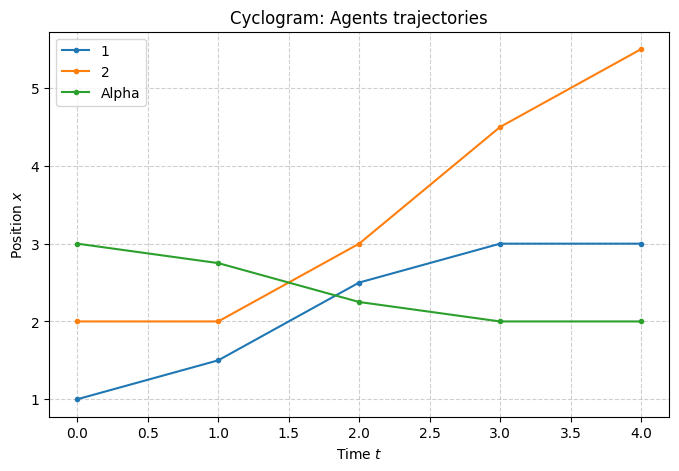

In [5]:
N = 3
x0 = np.array([1, 2, 3])
v0 = np.zeros(N, dtype=np.float32)

swarm = Swarm(x0, v0, 1)
for acc in accs:
    swarm.step(acc)
swarm.cyclogram()
plt.show()

## Простой подход управления на основе пружин

Пусть 2 агента одинаковой массы $m$ связаны пружиной жесткости $k$ и длиной $l_0$ в покое и находятся в координатах $x_1 < x_2$. В таком сеттинге ускорение (сила) двигателей агентов компенсируется/усиливается от натяжения/сжатия пружины, получается итоговое ускорение, которое мы и передаем в модель роя.

Пусть система управляется централизованно альфа-агентом в ($x_2$). У него есть заданная траектория $x(t)$, и он ей следует, а остальные адаптируют свои движения под условные пружины. То есть для первого пружины как бы нет при учете всех действующих сил, а для остальных есть. То есть $a_2 = \ddot{x}(t)$

Закон Гука при деформации пружины: $F = -k \cdot Δ x$, здесь деформация $Δ x = (x_2 - x_1) - l_0$. Итого на ведомого агента с противоположным знаком:
$$
a_1 = \frac{k}{m} (x_2 - x_1 - l_0)
$$

<!-- TODO: нам же надо аппроксимировать ускорение ср арифметическим между точками t и dt -->

На n агентов сейчас мы экстраполируем в предположении, что только соседние агенты соединены пружинами, а не каждый с каждым. Тогда на агента 1 влияет только натяжение между ним и агентом 2; $a_n = \ddot{x}(t)$, а все что между ними - натяжение перед и за:
$$a_i = \frac{F_{за} + F_{перед}}{m} = \frac{k}{m}(-(x_{i}-x_{i-1}-l_0)+(x_{i+1}-x_i - l_0))= \frac{k}{m}(-2x_i + x_{i-1}+x_{i+1}), 2 \le i \le n-1$$

In [7]:
class Controller(ABC):
    """
    Базовый класс, от которого предполагается наследовать остальные виды управления
    """
    def __init__(self, **kwargs):
        """
        Все параметры управления передаются в именнованных аргументах при инициализации
        """
        for key, value in kwargs.items():
            setattr(self, key, value)

    @abstractmethod
    def control_step(self, x_vec: np.ndarray, t: float, **kwargs) -> np.ndarray:
        """
        В каждом наследнике переопределяем метод, в который мы отдаем состояние роя и возвращаем ускорения, которые надо рою применить
        """
        pass

In [9]:
class AdjacentSpringsController(Controller):
    """
    Управление при известной для альфа-агента траектории, остальные на пружинках
    """
    def __init__(self, **kwargs):
        """
        Обязательные параметры: m, k, ell_0, функция ddot_x (t)
        """
        super().__init__(**kwargs)

    def control_step(self, x_vec: np.ndarray, t: float, **kwargs) -> np.ndarray:
        accs = np.zeros(len(x_vec))
        accs[-1] = self.ddot_x(t)
        accs[0] = self.k / self.m * (x_vec[1]-x_vec[0] - self.ell_0)
        for i in range(1, len(accs)-1):
            accs[i] = self.k / self.m * (-2 * x_vec[i] + x_vec[i-1] + x_vec[i+1])
        return accs

Пример использования:

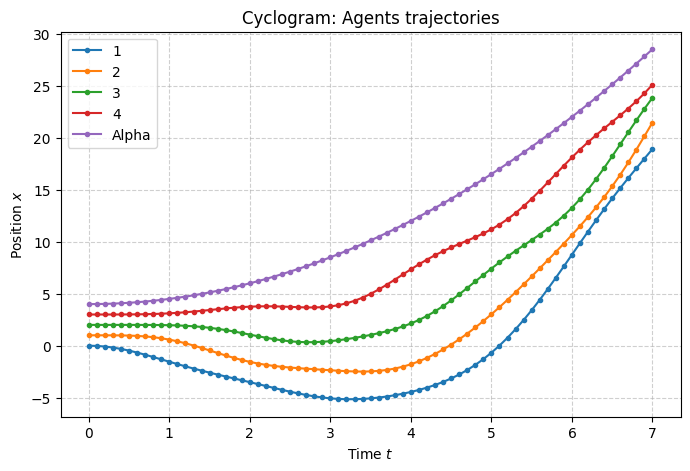

In [10]:
N = 5
x0 = np.arange(N)
v0 = np.zeros(N, dtype=np.float32)
dt = 0.1
swarm = Swarm(x0, v0, dt)
cntrl = AdjacentSpringsController(m=1.0, k=4.0, ell_0=2.0, ddot_x=lambda t: 1)
for t in range(70):
    acc = cntrl.control_step(swarm.x, t*dt)
    swarm.step(acc)
swarm.cyclogram()
plt.show()

Такая простая модель на пружинках может показать себя хорошо на небольших интервалах, если подобрать удачные $k, Δ t$ и общее $t$, но на долгосроке они всё равно начинают сталкиваться (в сущности закон Гука и не гарантирует ничего), в том числе из-за неадаптивного ускорения, что нереалистично

Дорабатываем подход с помощью [статьи](https://arxiv.org/abs/2209.00174):
1. Добавляем ограничители ускорений и сглаживание сил как раз чтобы не врезаться
2. Цель "следование заданной траектории" меняется на "достижение и поддержание желаемой скорости при ограничении в ускорении"
3. Виртуальные пружинки связывают агента и машину перед ним (без влияния агента сзади*)
4. Пока в предположении, что любые машины могут коммуницировать друг с другом, то есть не берем из статьи подсчет в зависимости от длины.


\* на предыдущем сеттинге был испытан вариант без учета агента сзади, столкновение происходило еще быстрее, так как еще меньше контроля движения и сдержек


Коэффициент $c$ регулирования ускорения определяется через максимальное ускорение и желаемую скорость:
$$c = \frac{m \cdot a_{max}}{v_d}$$
Тогда каждый период $Δ t$ (в статье $τ$, время реагирования) альфа-агент имеет ускорение $$a_n = \frac{c}{m} (v_d - v_n)$$
Остальные агенты ориентируются на пружинку перед ним + коэффициент затухания колебаний. Основная формула силы получается:
$$F = F_{spring} + F_{damping} = k Δ x + b Δ v$$

Длину пружинки понимаем адаптивно, фиксировано теперь только безопасное расстояние $s_0$ между машинами:
$$l_i = s_0 + Δ t \cdot v_i$$

$$b [\frac{кг}{с}] = \max{(\frac{m}{\tau}, \sqrt{k m})}$$

В статье не упоминается явно $Δ x_{max}$ для вычисления $k$, полагаем сейчас
$$k_i = \frac{m a_{max}}{l_i}$$
Итого
$$a_i = \frac{1}{m} (k_i \cdot (x_{i+1} - x_i - l_i) + b_i \cdot (v_{i+1} - v_i)), i<n$$

Машинки расставим на минимальном безопасном расстоянии друг от друга $s_0$

In [11]:
class SMDSimpleController(Controller):
    def __init__(self, **kwargs):
        """
        Обязательные параметры: m, s_0, dt, a_max, v_d
        """
        super().__init__(**kwargs)
        self.c = self.m * self.a_max / self.v_d

    def control_step(self, x_vec: np.ndarray, v_vec: np.ndarray, **kwargs) -> np.ndarray:
        accs = np.zeros(len(x_vec))
        accs[-1] = self.c / self.m * (self.v_d - v_vec[-1])
        for i in range(len(accs)-1):
            ell_i = self.s_0 + self.dt * v_vec[i]
            k_i = self.m * self.a_max / ell_i
            b_i = max(self.m / self.dt, (k_i * self.m)**0.5)
            accs[i] = (k_i * (x_vec[i+1] - x_vec[i] - ell_i) + b_i * (v_vec[i+1] - v_vec[i])) / self.m
        return accs

Используем фиксированные параметры из статьи, можно посмотреть на успешную поездку в шорт-ране и в долгую

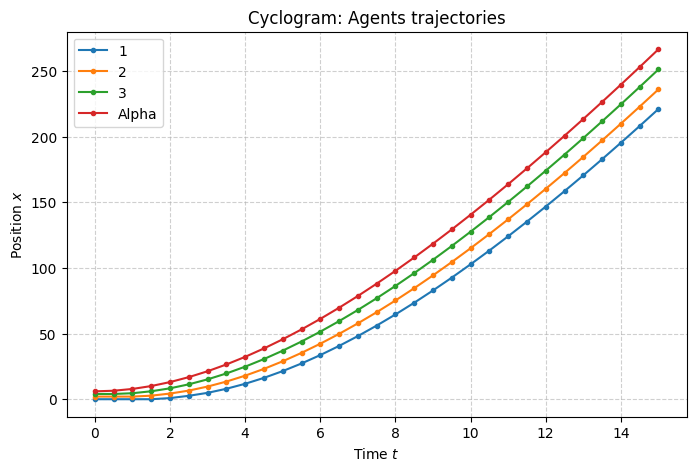

In [12]:
N = 4
s_0 = 2
x0 = np.arange(0, N * s_0, s_0)
v0 = np.zeros(N, dtype=np.float32)
dt = 0.5
swarm = Swarm(x0, v0, dt)
cntrl = SMDSimpleController(m=1676.0, a_max=3.7, v_d=33.3, s_0=s_0, dt=dt)
for t in range(30):
    acc = cntrl.control_step(swarm.x, swarm.v)
    swarm.step(acc)
swarm.cyclogram()
plt.show()

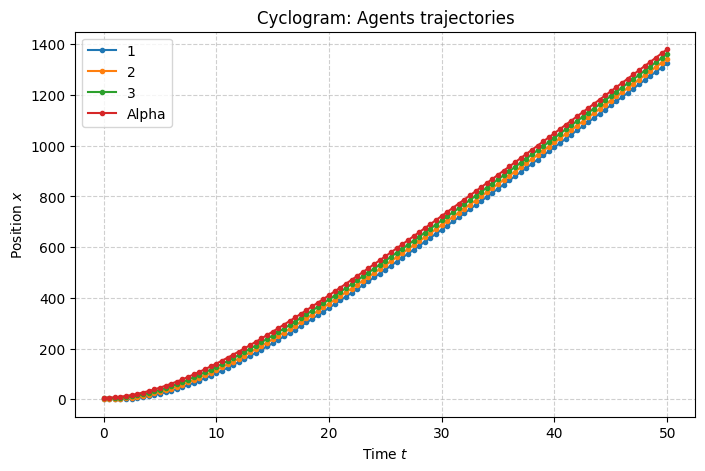

In [13]:
N = 4
s_0 = 2
x0 = np.arange(0, N * s_0, s_0)
v0 = np.zeros(N, dtype=np.float32)
dt = 0.5
swarm = Swarm(x0, v0, dt)
cntrl = SMDSimpleController(m=1676.0, a_max=3.7, v_d=33.3, s_0=s_0, dt=dt)
for t in range(100):
    acc = cntrl.control_step(swarm.x, swarm.v)
    swarm.step(acc)
swarm.cyclogram()
plt.show()

И можно поставить кастомные параметры, чтобы посмотреть что ограничители адаптируются и под них

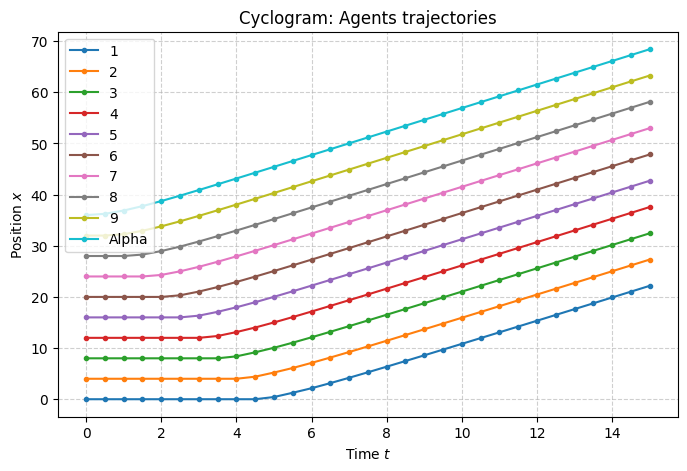

In [14]:
N = 10
s_0 = 4
x0 = np.arange(0, N * s_0, s_0)
v0 = np.zeros(N, dtype=np.float32)
dt = 0.5
swarm = Swarm(x0, v0, dt)
cntrl = SMDSimpleController(m=100.0, a_max=2.0, v_d=2.3, s_0=s_0, dt=dt)
for t in range(30):
    acc = cntrl.control_step(swarm.x, swarm.v)
    swarm.step(acc)
swarm.cyclogram()
plt.show()